<a href="https://colab.research.google.com/github/IbtissamSaadi/vit-pytorch/blob/main/Viit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!pip install vit_pytorch
!pip install timm

In [45]:
import torch, torchvision
import numpy as np
import pandas as pd
#from tqdm import tqdm
import PIL.Image as Image
#import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt
#from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, classification_report
#from glob import glob
#import shutil
import timm
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models, datasets
from vit_pytorch import ViT

import time

#%matplotlib inline
#%config InlineBackend.figure_format='retina'
#sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
#rcParams['figure.figsize'] = 12, 8

torch.manual_seed(42)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = True
Dpath = '/content/drive/MyDrive/CK+48'
#Bs_Train = 100
#Bs_Test = 1000

tform_mnist = torchvision.transforms.Compose([
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomRotation(30),
    #torchvision.transforms.CenterCrop((16)),
    #torchvision.transforms.RandomAffine(degrees=40, scale=(.3, 1.1), shear=0.15),
    #torchvision.transforms.Resize((48,48)),                                          
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,),(0.5,))
])

"""
"""
"""
path_train = '/content/drive/MyDrive/FER2013 small dataset/train'
path_vaild = '/content/drive/MyDrive/FER2013 small dataset/test'
#apply multiple transformer after each other
transforms_vaild = torchvision.transforms.Compose([
                                     #torchvision.transforms.Resize((224,)),
                                     torchvision.transforms.Grayscale(),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.5026,), (0.2595,))
                                     ])

# For training, we add some augmentation. Networks are too powerful and would overfit.
transforms_train = torchvision.transforms.Compose([
                                      #torchvision.transforms.Resize((224,)),
                                      torchvision.transforms.Grayscale(),             
                                      torchvision.transforms.RandomHorizontalFlip(),
                                      #torchvision.transforms.RandomRotation(30),
                                      #torchvision.transforms.CenterCrop((16)),
                                      #torchvision.transforms.RandomAffine(degrees=40, scale=(.3, 1.1), shear=0.15),
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize((0.5066,), (0.2627,))
                                     ])
"""
"""
transforms_train = transforms.Compose([
         transforms.Grayscale(),#Use ImageFolder to expand to three channels by default, just change it back
         transforms.RandomHorizontalFlip(),#Random Flip
         transforms.ColorJitter(brightness=0.5, contrast=0.5),#Adjust brightness and contrast randomly
    transforms.ToTensor()
])
transforms_vaild = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
"""
"""
data_train = torchvision.datasets.ImageFolder(root=path_train,transform=transforms_train)
data_vaild = torchvision.datasets.ImageFolder(root=path_vaild,transform=transforms_vaild)
print("Classes: ")
classes = data_train.classes 
print(classes)
train_set = torch.utils.data.DataLoader(dataset=data_train,batch_size=64,shuffle=True)
vaild_set = torch.utils.data.DataLoader(dataset=data_vaild,batch_size=64,shuffle=False)
"""

orig_set = datasets.ImageFolder(root=Dpath, transform=tform_mnist )  #  dataset
n = len(orig_set)  # total number of examples
print("Classes: ")
print(orig_set.classes)
n_test = int(0.20 * n)  # take ~10% for test

test_set = torch.utils.data.Subset(orig_set, range(n_test))  # take first 30%
print("test ",len(test_set))
train_set = torch.utils.data.Subset(orig_set, range(n_test, n))  # take the rest 
print("train ",len(train_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, 
                                          shuffle = True )
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, 
                                          shuffle = False)


"""
DOWNLOAD_PATH = '/data/mnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
"""
"""
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

for param in vit_model.parameters():
      param.requires_grad = False

num_inputs = vit_model.head.in_features
last_layer = nn.Linear(num_inputs, len(orig_set.classes))
vit_model.head = last_layer
"""
"""
def create_model(n_classes):
  model = timm.create_model('vit_base_patch16_224', pretrained=True)
  n_features = model.head.in_features
  model.head = nn.Linear(n_features, n_classes)
  return model
"""


def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  #scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for inputs, labels in data_loader:
    #inputs = inputs.to(device)
    #labels = labels.to(device)
    #start forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    #backward pass
    loss.backward()#calculate gradient
    optimizer.step()#update wightes
    optimizer.zero_grad()#empty our gradients for the next iteration
  #scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  #to track the history for evaluate the model and get the accuracy
  #we don't calculate the gradient
  with torch.no_grad():
    for inputs, labels in data_loader:
      #inputs = inputs.to(device)
      #labels = labels.to(device)
      outputs = model(inputs)
      #actual predict _ we don't need it, predict
      _, preds = torch.max(outputs, dim=1)#choose highest prob for every output and class them to the right class
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

def train_model(model, train_loaders, test_loaders, n_epochs):
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  #scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
  loss_fn =  nn.CrossEntropyLoss()
  history = defaultdict(list)

  dataset_sizes_train = len(train_set)
  dataset_sizes_test = len(test_set)
  best_accuracy = 0
  for epoch in range(n_epochs):
    print(f'Epoch {epoch+1 }/{n_epochs}')
    print('-' * 30)
    train_acc, train_loss = train_epoch(
      model,
      train_loaders,
      loss_fn,
      optimizer,
      #scheduler,
      dataset_sizes_train
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      test_loaders,
      loss_fn,
      dataset_sizes_test
    )
    path = "/content/drive/MyDrive/checkpointtload4.pth" 
    checkpoint = {
        
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    torch.save(checkpoint, path)
  
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    #if val_loss > 2.50:
     #  break
   
    if val_acc > best_accuracy:
      best_accuracy = val_acc
      #es = 0
      torch.save(model.state_dict(), 'best_model_state.pth')
    #else:
     # es += 1
      #print("Counter {} of 5".format(es))

      #if es > 10:
       # print(f'Early stopping with best_acc: {best_accuracy}')
        #break
  print(f'Best val accuracy: {best_accuracy} , Accuracy: {100 * best_accuracy}')
  #model.load_state_dict(torch.load('best_model_state.pth'))
  return model, history

model = ViT(image_size=48, patch_size=16, num_classes=7, channels=3,
             dim=256, depth=6, heads=8, mlp_dim=256, dropout = 0.1, emb_dropout = 0.1)

optimizer = optim.Adam(model.parameters(), lr=0.001)
if load_model : 
   loaded_check = torch.load("/content/drive/MyDrive/checkpointtload4.pth")
   #loss = loaded_check['loss']
   #print("loss",loss)
#epoch = loaded_check['epoch']
   model.load_state_dict(loaded_check['state_dict'])
   optimizer.load_state_dict(loaded_check['optimizer'])
   

"""
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
for param in vit_model.parameters():
      param.requires_grad = False

num_inputs = vit_model.head.in_features
vit_model.head = nn.Linear(num_inputs, 7)
"""
start_time = time.time()
base_model, history = train_model(model, train_loader, test_loader, 5)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Classes: 
['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
test  132
train  530
Epoch 1/5
------------------------------
Train loss 0.2197646200656891 accuracy 0.939622641509434
Val   loss 7.496143182118733 accuracy 0.0

Epoch 2/5
------------------------------
Train loss 0.11659658369090822 accuracy 0.960377358490566
Val   loss 5.5765312512715655 accuracy 0.015151515151515152

Epoch 3/5
------------------------------
Train loss 0.12601610821568304 accuracy 0.9509433962264151
Val   loss 7.843168258666992 accuracy 0.0

Epoch 4/5
------------------------------
Train loss 0.08514510560780764 accuracy 0.9716981132075472
Val   loss 7.01501186688741 accuracy 0.015151515151515152

Epoch 5/5
------------------------------
Train loss 0.05098830225567023 accuracy 0.9905660377358491
Val   loss 7.348455905914307 accuracy 0.015151515151515152

Best val accuracy: 0.015151515151515152 , Accuracy: 1.5151515151515151
Execution time: 24.79 seconds


NameError: ignored

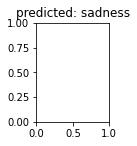

In [56]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      #inputs = inputs.to(device)
      #labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {orig_set.classes[preds[j]]}')
        imshow(inputs.data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return
show_predictions(base_model, orig_set.classes, n_images=8)

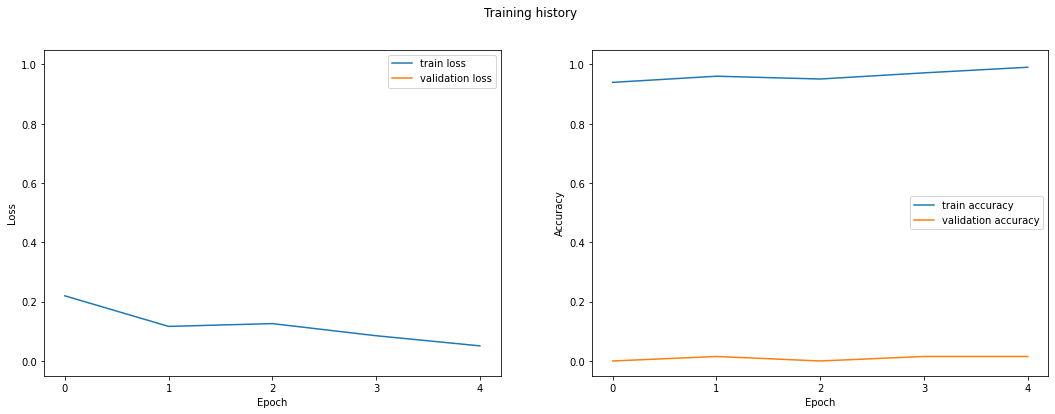

In [46]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  fig.suptitle('Training history')
plot_training_history(history)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [59]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      #inputs = inputs.to(device)
      #labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values
y_pred, y_test = get_predictions(base_model, test_loader)
print(classification_report(y_test, y_pred, target_names=orig_set.classes))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        98
    contempt       1.00      0.06      0.11        34
     disgust       0.00      0.00      0.00         0
        fear       0.00      0.00      0.00         0
       happy       0.00      0.00      0.00         0
     sadness       0.00      0.00      0.00         0
    surprise       0.00      0.00      0.00         0

    accuracy                           0.02       132
   macro avg       0.14      0.01      0.02       132
weighted avg       0.26      0.02      0.03       132



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [69]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        #inputs = inputs.to(device)
        #classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))# acc par class

tensor([[ 0.,  0., 48.,  6.,  0., 31., 13.],
        [ 0.,  2.,  1., 18.,  4.,  6.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])
tensor([0.0000, 0.0588,    nan,    nan,    nan,    nan,    nan])


In [ ]:
# plot confusion matrix
idx2class = {v: k for k, v in images.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, flat_pred)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


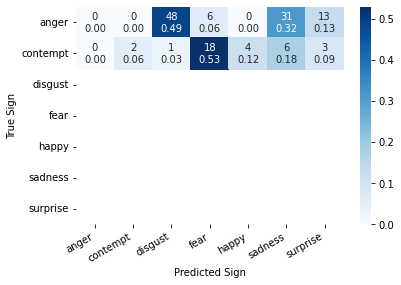

In [61]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, orig_set.classes)